In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np  
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import cv2
from sklearn.utils import shuffle

print(tf.__version__) 


Found GPU at: 
2.2.0


In [2]:
from IPython.display import clear_output, display
import os.path
from os import path
import shutil
import PIL
from pathlib import Path
from matplotlib import pyplot as plt

In [3]:
import random

In [261]:
from random import randrange

In [ ]:
BASE_DIR= '/mestrado/datasets'
IMG_ORG_DIR= path.join( BASE_DIR, 'carnaval_8lines_shuffle_parts', 'images')
LABELS_ORG_DIR= path.join( BASE_DIR, 'carnaval_8lines_shuffle_parts', 'labels')

In [4]:
def read_label( path):
  f= open( path)
  d= f.read()
  f.close()
  return d 

def write_label( path, text):
  f= open( path, "w")
  f.write( text)
  f.close()

def show_image( img, name= 'noname'):
  plt.imshow( img)
  plt.title( name)
  plt.show()

def show_gimage( img, name= 'noname'):
  plt.imshow( img, cmap= 'gray')
  plt.title( name)
  plt.show()

def _load_image( path):
  # return cv2.imread( path, cv2.IMREAD_GRAYSCALE)
  return cv2.imread( path)
  
def write_image( path, img):
  cv2.imwrite( path, img)

def resize( img, scale_percent= 60, verbose=False):
  #scale_percent = 60 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  if verbose:
    print( "scale", scale_percent)
    print( "dim", dim)
  # resize image
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 

In [4]:
def _load_all():
    all_images= glob( os.path.join( IMG_ORG_DIR, "*.jpg"))
    # all_images= glob( '/content/carnaval_8lines/images/*.jpg')
    all_images.sort()
#     all_images= all_images[0:limit]
    all_images_content= [_load_image( f) for f in all_images]    
    all_images_content= np.asarray( all_images_content)

    all_labels=glob( os.path.join( LABELS_ORG_DIR, "*.pgn"))
    all_labels.sort()
#     all_labels= all_labels[0:limit]

    #ler todo o conteudo de labels e criar o vocabulario
    all_labels_content= [read_label( f) for f in all_labels]
#     all_labels_content= [label.split() for label in all_labels_content]

    # pega somente os primeiros 4, equivalente a 1 poagina
#     all_labels_content= [x[0:16] for x in all_labels_content]

    #complementa onde falta para completar 100
#     all_labels_content= [
#                 np.pad( x, (0,16-len(x)), 'constant', constant_values= 'end') for x in all_labels_content]
    return all_images, all_images_content, all_labels, all_labels_content


def cut( img, lines, cols):
    cuts= []
    h= (int)(img.shape[ 0]/lines)
    w= (int)(img.shape[ 1]/cols)

    for i in range(0,lines):
      for j in range(0,cols):
        cuts.append( img[ (i*h):(i+1)*h, (j*w):(j+1)*w])
    return np.array( cuts)

def rebuild( cuts):
    return np.concatenate( 
        (np.concatenate( (cuts[0], cuts[2], cuts[4], cuts[6], cuts[8], cuts[10], cuts[12], cuts[14]), axis=0),
        np.concatenate( (cuts[1], cuts[3], cuts[5], cuts[7], cuts[9], cuts[11], cuts[13], cuts[15]), axis=0)),
        axis= 1
    )

def _shuffle( img, label, k):
    cuts= cut( img, 8, 2)

    # newcuts, newlabel= np.random.shuffle( cuts)
    newcuts, newlabel= shuffle( cuts, label, random_state= k)
    newimg= rebuild( newcuts)
    return newimg, newlabel


In [ ]:
all_images, all_image_content, all_labels_files, label_content= _load_all()

In [ ]:
print( label_content[0])
show_image( all_image_content[0])

In [ ]:
len( label_content)

In [ ]:
# IMG_TARGET_DIR= path.join( BASE_DIR, 'carnaval_8lines_shuffle_from_parts20k', 'images')
# LABELS_TARGET_DIR= path.join( BASE_DIR, 'carnaval_8lines_shuffle_from_parts20k', 'labels')


# all_images, all_image_content, all_labels_files, label_content= _load_all()


# new_cuts= all_image_content
# new_labels= label_content

# size= len( new_cuts)
# def generate(N):
#     count= 0;
    
#     for i in range( 0, N):
#         id= [np.random.randint(0, size) for _ in range( 0, 16)]
        
#         img= rebuild( [new_cuts[j] for j in id])
#         label= [new_labels[j] for j in id]
#         tag= "shuffled_"+str(i+1).zfill(5) 
#         write_image( os.path.join( IMG_TARGET_DIR, tag+ ".jpg"), resize( img, 50))
#         write_label( os.path.join( LABELS_TARGET_DIR, tag+ ".pgn"), " ".join( label))
#         if i%500== 0:
#             print( i)
            
# generate(20000)
# print( "DONE")

In [ ]:
# all_labels=glob( os.path.join( LABELS_ORG_DIR, "*.pgn"))
# all_labels_content= [read_label( f) for f in all_labels]


In [ ]:
# labels= all_labels_content.sort()

In [ ]:
# all_labels_content[-100:-1]

In [5]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

In [6]:
def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    print (x.shape)
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)

In [ ]:
((all_image_content[0])[:,:,0:1]).shape

In [ ]:
# show_image( (all_image_content[0])[:,:,0:1])


In [ ]:
# # ELASTIC_ALPHA_SIGMA = ((1201, 10), (1501, 12), (991, 8))
# elastic_transform( (all_image_content[0])[:,:,0:1], 1201, 10)

In [7]:
!pip install Augmentor

You should consider upgrading via the 'C:\venv\mestrado\Scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
# https://github.com/mdbloice/Augmentor
samples_dir= "/mestrado/datasets/parts_sample"
# samples_dir= "C:/mestrado/datasets/carnaval_8lines_shuffle_parts/images"

In [5]:
import Augmentor


In [ ]:
p = Augmentor.Pipeline('C:\mestrado\datasets\carnaval_8lines_shuffle_parts\images')
p.random_distortion(probability=1, grid_width=5, grid_height=4, magnitude=8)
# p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
# p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
# p.flip_left_right(probability=0.5)
# p.flip_top_bottom(probability=0.5)
p.sample(80000)

In [ ]:
imagedir= "/mestrado/datasets/parts_sample/output"
labeldir= "/mestrado/datasets/parts_sample/output"

images= glob( imagedir+"/*.jpg")

In [ ]:
len( images)

In [ ]:
images[0]

In [ ]:
path.basename( images[0])

In [ ]:
label= path.basename( images[0])[27:32].replace( '_', '')
print( label)

In [ ]:
fname= str(seq)
"shuffled_"+str(i+1).zfill(5) 
#         write_image( os.path.join( IMG_TARGET_DIR, tag+ ".jpg"), resize( img, 50))
#         write_label( os.path.join( LABELS_TARGET_DIR, tag+ ".pgn"), " ".join( label))

In [14]:
def getlabel( file):
    return path.basename( file)[27:32].replace( '_', '')

In [8]:
#
# Gera shuffle a partir das imagens augmentadas
#
IMG_TARGET_DIR= 'C:\mestrado\datasets\carnaval_8lines_shuffle_from_parts_augmented\images'
LABELS_TARGET_DIR= 'C:\mestrado\datasets\carnaval_8lines_shuffle_from_parts_augmented\labels'

all_images= glob( "C:\mestrado\datasets\carnaval_8lines_shuffle_parts_augmented\images\*.jpg")

In [11]:
# all_images= glob( '/content/carnaval_8lines/images/*.jpg')
random.shuffle(all_images)

In [12]:
# #     all_images= all_images[0:limit]
# all_images_content= [_load_image( f) for f in all_images]    
# all_images_content= np.asarray( all_images_content)

KeyboardInterrupt: 

In [ ]:
# # all_images, all_image_content, all_labels_files, label_content= _load_all()

# new_cuts= all_images_content
# new_labels= [getlabel(img) for img in all_images]

In [ ]:
# len( new_cuts)

In [ ]:
# int(len( new_labels)/16)

In [ ]:
# new_labels[0:16]

In [16]:
count= 0;
i= 0

while i< len( all_images):
    id= [_ for _ in range(i, i+16)]

    new_cuts= np.asarray([_load_image( all_images[j]) for j in id])
    img= rebuild( new_cuts)

    label= [getlabel( all_images[j]) for j in id]       
    
    tag= "augmented_"+str(count+1).zfill(5) 
    write_image( os.path.join( IMG_TARGET_DIR, tag+ ".jpg"), resize( img, 50))
    write_label( os.path.join( LABELS_TARGET_DIR, tag+ ".pgn"), " ".join( label))
    count= count+1
    if count%100== 0:
        print( count)
        
    i= i+ 16

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


In [ ]:
# https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation

In [9]:
!pip install pandas

You should consider upgrading via the 'C:\venv\mestrado\Scripts\python.exe -m pip install --upgrade pip' command.


In [10]:
import numpy as np
import pandas as pd
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

In [122]:
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    print( alpha, sigma, alpha_affine)
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [12]:
# Define function to draw a grid
def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=(255,))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=(255,))


In [13]:
%matplotlib inline


In [14]:
im = cv2.imread("C:/mestrado/datasets/unified/final-32K-8lines/valid/images/b3__e5__Bb2_Nc6_0296_0723_L_part1_scan0364.jpg", -1)

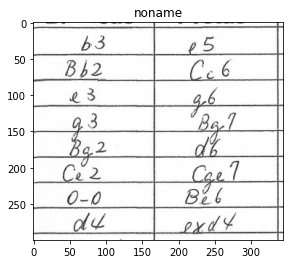

In [16]:
show_image( im)

690 27.6 27.6


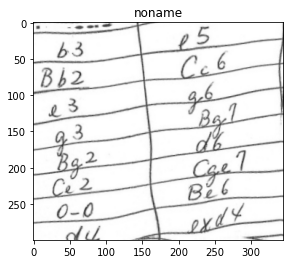

In [137]:
show_image( elastic_transform(im, im.shape[1] * 2, im.shape[1] * 0.08, im.shape[1] * 0.08))

345 17.25 17.25


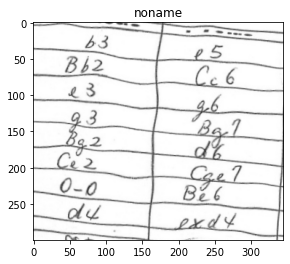

In [169]:
show_image( elastic_transform(im, im.shape[1] * 1, im.shape[1] * 0.05, im.shape[1] * 0.05))

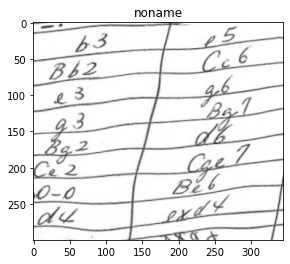

In [61]:
show_image( im_merge_t)

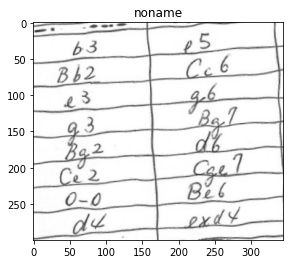

In [22]:
show_image( elastic_transform(im, 100, 10, 10))

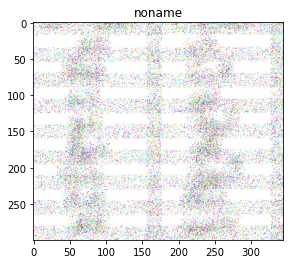

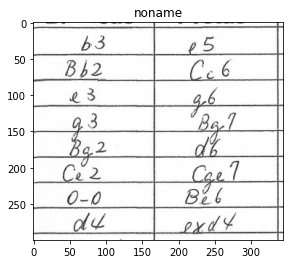

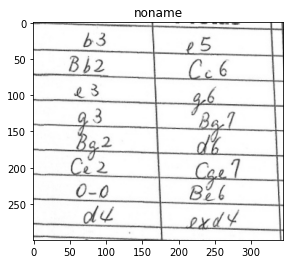

In [62]:
show_image( elastic_transform(im, 10, 0, 0))
show_image( elastic_transform(im, 0, 10, 0))
show_image( elastic_transform(im, 0, 0, 10))


In [46]:
random_state= np.random.RandomState(None)

In [47]:
random_state.rand( 0)

array([], dtype=float64)

In [48]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

In [311]:

# https://gist.github.com/erniejunior/601cdf56d2b424757de5
def elastic_transform_2(image, alpha, sigma,random_state=None):
#     print( alpha, sigma)
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

#     x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
#     print (x.shape)
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)

In [312]:
def transform( img):
    # ELASTIC_ALPHA_SIGMA = ((1201, 10), (1501, 12), (991, 8))
    return elastic_transform_2(img, 1201, 10)  #random.randint( 991, 1501), random.randint( 8, 12))
    

1201 10
(300, 345, 3)


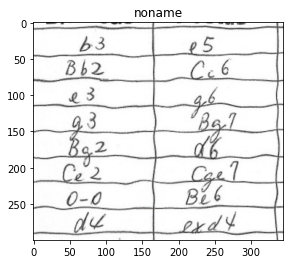

In [298]:
show_image( transform( im))

In [174]:
random.randint(1, 3)

2

1378 11
(300, 345, 3)


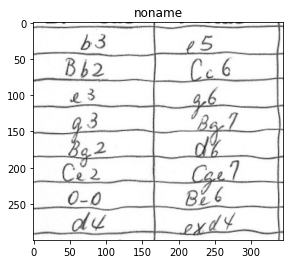

In [223]:
show_image( elastic_transform_2(img, 
                                random.randint( 991, 1501),
                                random.randint( 0, 12)))

In [327]:
files= glob( "C:/mestrado/datasets/unified/final-32K-8lines/train/images.aug/syn*.jpg")



In [238]:
print( len( files))

20217


In [260]:
# Imported PIL Library from PIL import Image

# Open an Image
def open_image(path):
    newImage = Image.open(path)
    return newImage

# Save Image
def save_image(image, path):
    image.save(path, 'jpg')


# Create a new image with the given size
def create_image(i, j):
    image = Image.new("RGB", (i, j), "white")
    return image


# Get the pixel from the given image
def get_pixel(image, i, j):
    # Inside image bounds?
    width, height = image.size
    if i > width or j > height:
        return None

    # Get Pixel
    pixel = image.getpixel((i, j))
    return pixel

# Create a Grayscale version of the image
def convert_grayscale(image):
    # Get size
    width, height = image.size

    # Create new Image and a Pixel Map
    new = create_image(width, height)
    pixels = new.load()

    # Transform to grayscale
    for i in range(width):
        for j in range(height):
            # Get Pixel
            pixel = get_pixel(image, i, j)

            # Get R, G, B values (This are int from 0 to 255)
            red =   pixel[0]
            green = pixel[1]
            blue =  pixel[2]

            # Transform to grayscale
            gray = (red * 0.299) + (green * 0.587) + (blue * 0.114)

            # Set Pixel in new image
            pixels[i, j] = (int(gray), int(gray), int(gray))

    # Return new image
    return new


# Create a Half-tone version of the image
def convert_halftoning(image):
    # Get size
    width, height = image.size

    # Create new Image and a Pixel Map
    new = create_image(width, height)
    pixels = new.load()

    # Transform to half tones
    for i in range(0, width-1, 2):
        for j in range(0, height-1, 2):
            # Get Pixels
            p1 = get_pixel(image, i, j)
            p2 = get_pixel(image, i, j + 1)
            p3 = get_pixel(image, i + 1, j)
            p4 = get_pixel(image, i + 1, j + 1)

            # Transform to grayscale
            gray1 = (p1[0] * 0.299) + (p1[1] * 0.587) + (p1[2] * 0.114)
            gray2 = (p2[0] * 0.299) + (p2[1] * 0.587) + (p2[2] * 0.114)
            gray3 = (p3[0] * 0.299) + (p3[1] * 0.587) + (p3[2] * 0.114)
            gray4 = (p4[0] * 0.299) + (p4[1] * 0.587) + (p4[2] * 0.114)

            # Saturation Percentage
            sat = (gray1 + gray2 + gray3 + gray4) / 4

            # Draw white/black depending on saturation
            if sat > 223:
                pixels[i, j]         = (255, 255, 255) # White
                pixels[i, j + 1]     = (255, 255, 255) # White
                pixels[i + 1, j]     = (255, 255, 255) # White
                pixels[i + 1, j + 1] = (255, 255, 255) # White
            elif sat > 159:
                pixels[i, j]         = (255, 255, 255) # White
                pixels[i, j + 1]     = (0, 0, 0)       # Black
                pixels[i + 1, j]     = (255, 255, 255) # White
                pixels[i + 1, j + 1] = (255, 255, 255) # White
            elif sat > 95:
                pixels[i, j]         = (255, 255, 255) # White
                pixels[i, j + 1]     = (0, 0, 0)       # Black
                pixels[i + 1, j]     = (0, 0, 0)       # Black
                pixels[i + 1, j + 1] = (255, 255, 255) # White
            elif sat > 32:
                pixels[i, j]         = (0, 0, 0)       # Black
                pixels[i, j + 1]     = (255, 255, 255) # White
                pixels[i + 1, j]     = (0, 0, 0)       # Black
                pixels[i + 1, j + 1] = (0, 0, 0)       # Black
            else:
                pixels[i, j]         = (0, 0, 0)       # Black
                pixels[i, j + 1]     = (0, 0, 0)       # Black
                pixels[i + 1, j]     = (0, 0, 0)       # Black
                pixels[i + 1, j + 1] = (0, 0, 0)       # Black

    # Return new image
    return new


# Return color value depending on quadrant and saturation
def get_saturation(value, quadrant):
    if value > 223:
        return 255
    elif value > 159:
        if quadrant != 1:
            return 255
        return 0
    elif value > 95:
        if quadrant == 0 or quadrant == 3:
            return 255
        return 0
    elif value > 32:
        if quadrant == 1:
            return 255
        return 0
    else:
        return 0

# Create a dithered version of the image
def convert_dithering(image):
    # Get size
    width, height = image.size

    # Create new Image and a Pixel Map
    new = create_image(width, height)
    pixels = new.load()

  # Transform to half tones
    for i in range(0, width-1, 2):
        for j in range(0, height-1, 2):
            # Get Pixels
            p1 = get_pixel(image, i, j)
            p2 = get_pixel(image, i, j + 1)
            p3 = get_pixel(image, i + 1, j)
            p4 = get_pixel(image, i + 1, j + 1)

            # Color Saturation by RGB channel
            red   = (p1[0] + p2[0] + p3[0] + p4[0]) / 4
            green = (p1[1] + p2[1] + p3[1] + p4[1]) / 4
            blue  = (p1[2] + p2[2] + p3[2] + p4[2]) / 4

            # Results by channel
            r = [0, 0, 0, 0]
            g = [0, 0, 0, 0]
            b = [0, 0, 0, 0]

            # Get Quadrant Color
            for x in range(0, 4):
                r[x] = get_saturation(red, x)
                g[x] = get_saturation(green, x)
                b[x] = get_saturation(blue, x)

            # Set Dithered Colors
            pixels[i, j]         = (r[0], g[0], b[0])
            pixels[i, j + 1]     = (r[1], g[1], b[1])
            pixels[i + 1, j]     = (r[2], g[2], b[2])
            pixels[i + 1, j + 1] = (r[3], g[3], b[3])

    # Return new image
    return new


# Create a Primary Colors version of the image
def convert_primary(image):
    # Get size
    width, height = image.size

    # Create new Image and a Pixel Map
    new = create_image(width, height)
    pixels = new.load()

    # Transform to primary
    for i in range(width):
        for j in range(height):
            # Get Pixel
            pixel = get_pixel(image, i, j)

            # Get R, G, B values (This are int from 0 to 255)
            red =   pixel[0]
            green = pixel[1]
            blue =  pixel[2]

            # Transform to primary
            if red > 127:
                red = 255
            else:
                red = 0
            if green > 127:
                green = 255
            else:
                green = 0
            if blue > 127:
                blue = 255
            else:
                blue = 0

            # Set Pixel in new image
            pixels[i, j] = (int(red), int(green), int(blue))

    # Return new image
    return new


In [328]:
def transform_and_save( f):
    img= _load_image( f)
    n = randrange( 4)
    if n== 1:
        img1= transform( img)
#         print( 'transformed => '+ f)
#         show_image( img1)
        write_image( f, img1)

for i in range( 0, len( files)): 
    if i%100== 0:
        print( i)
    transform_and_save( files[i])
        

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [321]:
fname= "C:/mestrado/datasets/unified/final-32K-8lines/train/images/syn_08421.jpg"

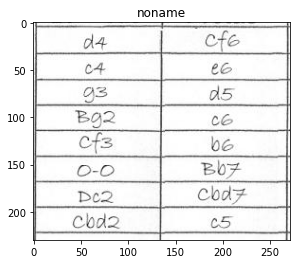

In [326]:
show_image( open_image(fname))

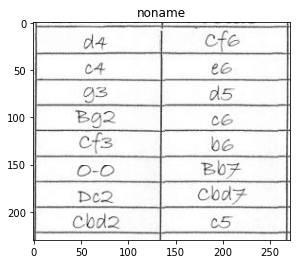

In [322]:
show_image( convert_grayscale( open_image(fname)))

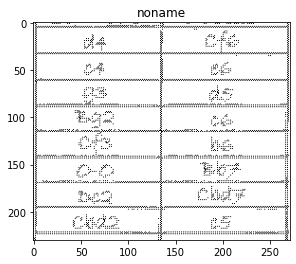

In [323]:
show_image( convert_halftoning( open_image(fname)))

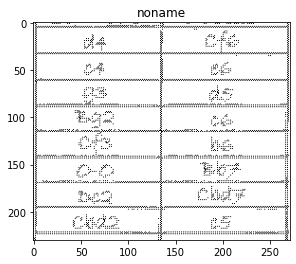

In [324]:
show_image( convert_dithering( open_image(fname)))

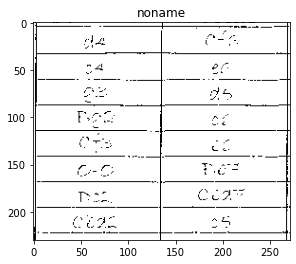

In [325]:
show_image( convert_primary( open_image(fname)))

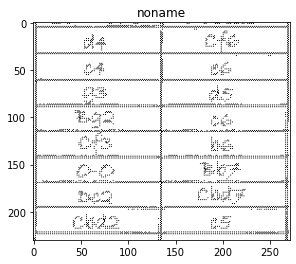

In [329]:
imx= open_image(fname)
imx= convert_grayscale( imx)
imx= convert_halftoning( imx)
imx= convert_dithering( imx)
imx= convert_primary( imx)
show_image( imx)
#imx.save("C:/image/test.jpg", 'jpeg')


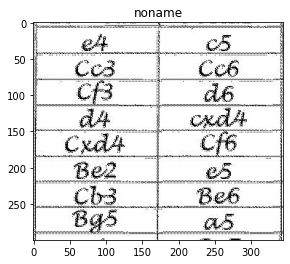

In [284]:
show_image( _load_image( "C:/image/test.jpg"))

In [316]:
def _save( img, f):
    img.save(f, 'jpeg')
#     show_image( imx)

def transform_color( f):
    imx= open_image(f)
    n = randrange( 40)
    if n== 1:
        imx= convert_grayscale( imx)
        _save( imx, f)
    if n== 2:
        imx= convert_halftoning( imx)
        _save( imx, f)
    if n== 3:
        imx= convert_dithering( imx)
        _save( imx, f)
    if n== 5:
        imx= convert_primary( imx)
        _save( imx, f)


for i in range( 0, len( files)): 
    if i%100== 0:
        print( i)
    transform_color( files[i])



0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18